In this notebook I would like to implement my first **Neural Network** from scratch.
To do so, I will apply it to the [MNIST database](https://en.wikipedia.org/wiki/MNIST_database): a large database of handwritten digits. We will predict if a given digit is a zero or not.

The main idea of [neural networks](https://en.wikipedia.org/wiki/Artificial_neural_network) is the following.
- We start with some random parameters W and b.
- Next, we implement the **forward propagation step**. This has several *layers*, each of which predicts an output
$ g (W * A + b) $,
where
$ A $ 
is the output of the previous layer and 
$ g $ 
is the [*activation function*](https://en.wikipedia.org/wiki/Activation_function). 
Clearly, the input of the fist layer is an image of the dataset.
- We compute the *Cross-Entropy cost* of the final output: this tends to zero when we make correct predictions.
- At this point, our goal is to minimize the cost to make better predictions using **gradient descent**. To do so, we look for a minimum of the cost function by taking the derivatives of the cost function and "making a step towards the minimum" changing the parameters W and b. This is called the **backward propagation step**.

Now, first of all let's import the libraries.

In [1]:
import numpy as np 

%matplotlib inline
import matplotlib as mpl 
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml

Here are some **notations for parameters and hyperparameters**:

- *L* will denote the number of layers, for example L=3
- *layer_dimension* has all the information about number of nodes in each layer: it is a list of length L
- the learning rate for the gradient descent is *alpha* (this is the length of the step we're making)
- *W* and *b* are the parameters for the linear steps, to be initialised at random
- *activs* has the information about the activation function of the hidden and output layers: it is a list [hidden activation, output activation]

In [2]:
# random initialization of W and b

def initialization(layer_dimensions):
    param = {}
    L = len(layer_dimensions)
    for l in range(1, L):
        param['W'+str(l)] = np.random.randn(layer_dimensions[l], layer_dimensions[l-1])*np.sqrt(2. / layer_dimensions[l-1])
        param['b'+str(l)] = np.zeros((layer_dimensions[l],1))
    return param

**Forward propagation** steps:

1) compute the output of the $ l $-th layer $ Z[l] = W[l] * A[l-1] + b[l] $

2) apply the activation function $ g $ to $ Z[l] $ and put $ A[l] = g(Z[l]) $

3) store the values in cache for the backpropagation

4) iterate for every layer $ l= 1, \dots , L $

In [3]:
# the next function applies the activation g to the linear combination of W, A and b
def activ_forward(A_prev, W, b, activ):
    
    Z = np.dot(W,A_prev) + b
    lin_cache = (A_prev, W, b)
    
    if activ == 'tanh':
        A = np.tanh(Z)
        
    elif activ == 'relu':
        A = np.maximum(Z,0)
        
    elif activ == 'sigmoid':
        A = 1. /(1. + np.exp(-Z))
        
    else:
        A = None
        print('Unknown activation function!')
    
    cache = (lin_cache, Z)
    return A, cache

# the following function implements forward propagation as explained above
def model_forward(X, param, activs= ['relu', 'sigmoid']):
    
    caches = []
    A = X
    L = len(param) // 2
    
    # implement linear transformation and activs[0] for the first L-1 layers
    for l in range(1, L):
        A_prev = A 
        A, cache = activ_forward(A_prev, param['W'+str(l)], param['b'+str(l)], activs[0])
        caches.append(cache)
    
    # in the ouput layer, use activs[1]
    AL, cache = activ_forward(A, param['W'+str(L)], param['b'+str(L)], activs[1])
    caches.append(cache)
    
    return AL, caches

Next, we **compute the cost**. Recall that the *Cross-Entropy cost* is 

$ J = - \frac{1}{m} \sum_{i=1}^m y^i \log (A^{[L]i}) + (1-y^i) \log (1-A^{[L]i}) $

where m is the number of training examples.

In [4]:
def comp_cost(AL, Y):
     
    m = Y.shape[1]
    cost = -np.sum((np.multiply(np.log(AL),Y) + np.multiply(np.log(1-AL),1-Y))/m)
    return np.squeeze(cost) # To make sure your cost's shape is what we expect (e.g. this turns [[7]] into 7)

We now turn to the **backward propagation**. To do so, we have to 

1) compute $ dA[L] $, the derivative of the cost $ J $ with respect to $ A[L] $

2) calculate the gradients $ dZ[l] = dA[l] * g'(Z[l]) $, where $ g' $ is the derivative of the activation function $ g $

3) compute $ dW[l], db[l], dA[l-1] $

4) iterate over $ l = L, \dots, 1 $

In [5]:
# compute g'(Z):
def der_activ(Z, activ):
    
    if activ == 'relu':
        derivate = Z
        derivate[Z<=0] = 0
        derivate[Z>0] = 1
        
    elif activ == 'tanh':
        a = np.tanh(Z)
        derivate = 1 - a**2
        
    elif activ == 'sigmoid':
        a = 1/(1+np.exp(-Z))
        derivate = a*(1-a) 
        
    else:
        derivate = None
        print('Unknown activation function!')
    
    return derivate

# steps 2) and 3):
def activ_backward(dA_prev, cache, activ):
    
    A_prev, W, b = cache[0]
    Z = cache[1]
    
    dZ = np.multiply(dA_prev, der_activ(Z, activ))
    
    m = A_prev.shape[1]
    dW = np.dot(dZ, A_prev.T) / m
    db = np.sum(dZ, axis=1, keepdims= True) / m
    dA = np.dot(W.T, dZ)
    
    return dA, dW, db

# the iteration:
def model_backward(AL, Y, caches, activs = ['relu', 'sigmoid']):
    
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) 
    
    # fist step of backprop:
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[L-1]
    dA_prev, dW_temp, db_temp = activ_backward(dAL, current_cache, activs[1])
    grads['dA' + str(L-1)] = dA_prev
    grads['dW' + str(L)] = dW_temp
    grads['db' + str(L)] = db_temp
    
    # loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev, dW_temp, db_temp = activ_backward(grads['dA'+str(l+1)], current_cache, activs[0])
        grads['dA' + str(l)] = dA_prev
        grads['dW' + str(l+1)] = dW_temp
        grads['db' + str(l+1)] = db_temp

    return grads

Now that we have all the gradients, we have to update the parameters W and b following the rule

$ X[l] = W[l] - \alpha * dW[l] $

$ b[l] = b[l] - \alpha * db[l] $

where $ \alpha $ is the learning rate.

In [6]:
def update_parameters(params, grads, alpha):
    
    param = params.copy()
    L = len(param) // 2 

    for l in range(L):
        param['W' + str(l+1)] = param['W' + str(l+1)] - alpha * grads['dW'+str(l+1)]
        param['b' + str(l+1)] = param['b' + str(l+1)] - alpha * grads['db'+str(l+1)]
        
    return param

#### We finally have all the functions we need to **implement our model**!!

In [7]:
def model(X, Y, layer_dimensions, alpha = 0.0075, num_iterations = 3000, activs = ['relu','sigmoid']):
    
    costs = []
    param = initialization(layer_dimensions)
    
    # implement gradient descent
    for i in range(0, num_iterations):

        # forward propagation
        AL, caches = model_forward(X, param, activs)
        
        # compute cost
        cost = comp_cost(AL, Y)
        
        # backward propagation
        grads = model_backward(AL, Y, caches, activs)
        
        # update parameters
        param = update_parameters(param, grads, alpha)
                
        # save the cost every 100 iterations
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)
    
    return param, costs

Before applying our function to the dataset, we write the function
**plot_cost** to have a visualization of the cost during the iterations

In [8]:
def plot_cost(costs, n_iter):
    plt.plot(list(range(int(n_iter/100))), costs, '-r')
    plt.title('Cost function')
    plt.xlabel('iterations (k)')
    plt.ylabel('cost')
    plt.show()

### Let's apply this to the MNIST dataset

In [9]:
# import the MNIST dataset:
mnist = fetch_openml('mnist_784', version = 1)

X, y = mnist['data'], mnist['target']
y = y.astype(np.uint8)

Lets plot some digits!


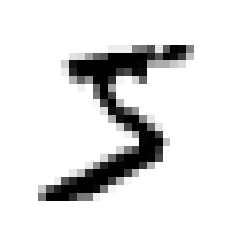

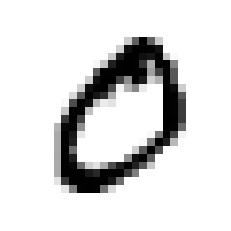

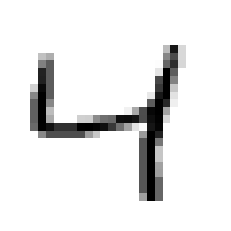

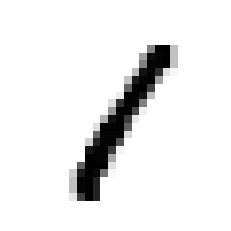

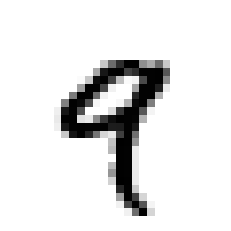

In [10]:
print('Lets plot some digits!')
for i in range(5):
    num = np.random.randn(1, X.shape[0])
    digit = X.loc[i].values
    plt.imshow(digit.reshape(28,28), cmap = 'binary')
    plt.axis('off')
    plt.show()

In [11]:
print ('Each image is of size (n_x): ' + str(X.shape[1]),'\n')

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

print('Shape of the training and testing vectors: \n')
print('X_train: ' + str(X_train.shape))
print('y_train: ' + str(y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('y_test:  '  + str(y_test.shape))

m_train = X_train.shape[0]
num_px = X_train.shape[1]
m_test = X_test.shape[0]

print ('\nNumber of training examples (m_train): ' + str(m_train))
print ('Number of testing examples: ' + str(m_test))

Each image is of size (n_x): 784 

Shape of the training and testing vectors: 

X_train: (60000, 784)
y_train: (60000,)
X_test:  (10000, 784)
y_test:  (10000,)

Number of training examples (m_train): 60000
Number of testing examples: 10000


According to the functions I wrote, X should have shape (n_x, m_train): I'll take the transpose to have this. 
Also, y should be of the shape (1, m_train). 
Same for the test set.

In [12]:
X_train = X_train.T.to_numpy()
y_train = y_train.values.reshape((1,X_train.shape[1]))
X_test = X_test.T.to_numpy()
y_test = y_test.values.reshape((1,X_test.shape[1]))

print('Updated shape of the training and testing vectors: \n')

print('X_train: ' + str(X_train.shape))
print('y_train: ' + str(y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('y_test:  '  + str(y_test.shape))

Updated shape of the training and testing vectors: 

X_train: (784, 60000)
y_train: (1, 60000)
X_test:  (784, 10000)
y_test:  (1, 10000)


Next, we *normalize* the data to have feature values between 0 and 1. 

In [13]:
X_mean = np.sum(X_train, axis=1)/X_train.shape[1]
X_mean = X_mean.reshape(X_train.shape[0],1)
X_var_square = np.sum(np.square(X_train))/X_train.shape[1]

X_train_norm = (X_train - X_mean)/ np.sqrt(X_var_square)
X_test_norm = (X_test - X_mean)/ np.sqrt(X_var_square)

In order to predict if an image is zero (y=0) or another number (y=1),
we take only part of the dataset and we make sure there are at least 30% of zeros.

In [14]:
m_train = 500

y_0 = (y_train[:,0:m_train]>0).astype(int)
print('There are ', '{:.3f}'.format(1-y_0.sum()/m_train),'% images of zeros')

X_0 = X_train_norm[:,0:m_train]
print('The training set has shape', X_0.shape)

y_0_test = (y_train[:,m_train: m_train +100]>0).astype(int)
X_0_test = X_train_norm[:,m_train: m_train +100]

There are  0.100 % images of zeros
The training set has shape (784, 500)


In [15]:
for i in range(X_train.shape[1]-2000, X_train.shape[1]):
    if y_train[0,i] == 0:
        y_0 = np.append(y_0,y_train[:,i].reshape(1,1), axis = 1)
        X_0 = np.append(X_0,X_train_norm[:,i].reshape(784,1), axis = 1)

print('The percentage of images of zeros is now ', '{:.3f}'.format(1-y_0.sum()/y_0.shape[1]))
print('The training set has shape', X_0.shape)

The percentage of images of zeros is now  0.352
The training set has shape (784, 694)


### The model:
Let's apply the model() function to the training and test sets X_0 and y_0 and plot the evolution of the cost function during the iterations of the algorithm. Note how this starts pretty high (0.7), but after few iterations it tends to zero.

In [ ]:
n_x = X_0.shape[0]    # input shape
n_y = 1               # output: 0 if it is a zero, 1 otherwise

layer_dimensions = [n_x, 3, n_y]
num_iter = 20000

param, costs = model(X_0, y_0, layer_dimensions, alpha = 0.075, num_iterations = num_iter)
plot_cost(costs, num_iter)

#### It's time to test the model on new images!

In [ ]:
def test_model(X_0, y_true, param, activ = ['relu','sigmoid']):

    AL, _ = model_forward(X_0, param, activ)
    
    y_pred = (AL > 0.5).astype(int) # 1 if non zero

    pred = (y_pred==y_true).astype(int)
    
    return pred.sum()/pred.shape[1]

In [ ]:
print('Accuracy of the train set:', test_model(X_0, y_0, param))
print('Accuracy of the test set:', test_model(X_0_test, y_0_test, param))

In [ ]:
def test_example(X, i):
    
    digit = X.loc[i].values
    plt.imshow(digit.reshape(28,28), cmap = 'binary')
    plt.axis('off')
    plt.show()
    
    digit = X.loc[i].values.reshape((784,1))
    digit_pred, _ = model_forward(digit, param, ['relu','sigmoid'])
    
    if np.squeeze(digit_pred) >0.5:  
        prediction = 'non zero'
    else: prediction = 'zero'
    
    print('The algorithm predicts a ' + prediction +  ' picture.')

In [ ]:
test_example(X, 26839)